**Descripcion del caso**

En este concurso, obtendrá acceso a dos conjuntos de datos similares que incluyen información del pasajero como nombre, edad, sexo, clase socioeconómica, etc. Un conjunto de datos se titula y el otro se titula .train.csvtest.csv

Train.csv contendrá los detalles de un subconjunto de los pasajeros a bordo (891 para ser exactos) y, lo que es más importante, revelará si sobrevivieron o no, también conocida como la "verdad sobre el terreno".

El conjunto de datos contiene información similar, pero no revela la "verdad sobre el terreno" de cada pasajero. Es su trabajo predecir estos resultados.test.csv

Usando los patrones que encuentre en los datos, prediga si los otros 418 pasajeros a bordo (encontrados en ) sobrevivieron.train.csvtest.csv

**Diccionario de datos** 

Variable	     Definición	        Llave
supervivencia  Supervivencia	    0 = No, 1 = Sí
pclase	       Clase de billete	    1 = 1º, 2 = 2º, 3 = 3º
sexo	       Sexo	
Edad	       Edad en años	
SIBNP	       # de hermanos / cónyuges a bordo del Titanic	
abrasar	       # de padres / hijos a bordo del Titanic	
Boleto	       Número de billete	
tarifa	       Tarifa de pasajero	
cabaña	       Número de cabina	
Embarcado	   Puerto de embarque	C = Cherburgo, Q = Queenstown, S = Southampton



**Notas variables**

pclass: Un indicador del estatus socioeconómico (SES)
1º = 2º Superior
= 3º Medio
= Edad inferior

: La edad es fraccional si es inferior a 1. Si se estima la edad, ¿es en forma de xx.5

sibsp: El conjunto de datos define las relaciones familiares de esta manera...
Hermano = hermano, hermana, hermanastro, hermanastra
Cónyuge = esposo, esposa (se ignoraron las amantes y los prometidos)

parch: El conjunto de datos define las relaciones familiares de esta manera...
Padre = madre, padre
Niño = hija, hijo, hijastra, hijastro
Algunos niños viajaron solo con una niñera, por lo tanto, parch = 0 para ellos.

In [2]:
#Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
#1.Carga de datos
test = pd.read_csv("C:/Users/douglas.garcia/Downloads/Test.csv")
train = pd.read_csv("C:/Users/douglas.garcia/Downloads/Train.csv")


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [6]:
#Eliminando columnas
test=test.drop(['Name','Cabin','Ticket'],axis=1)

In [7]:
#Analisis exploratorio 
test.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


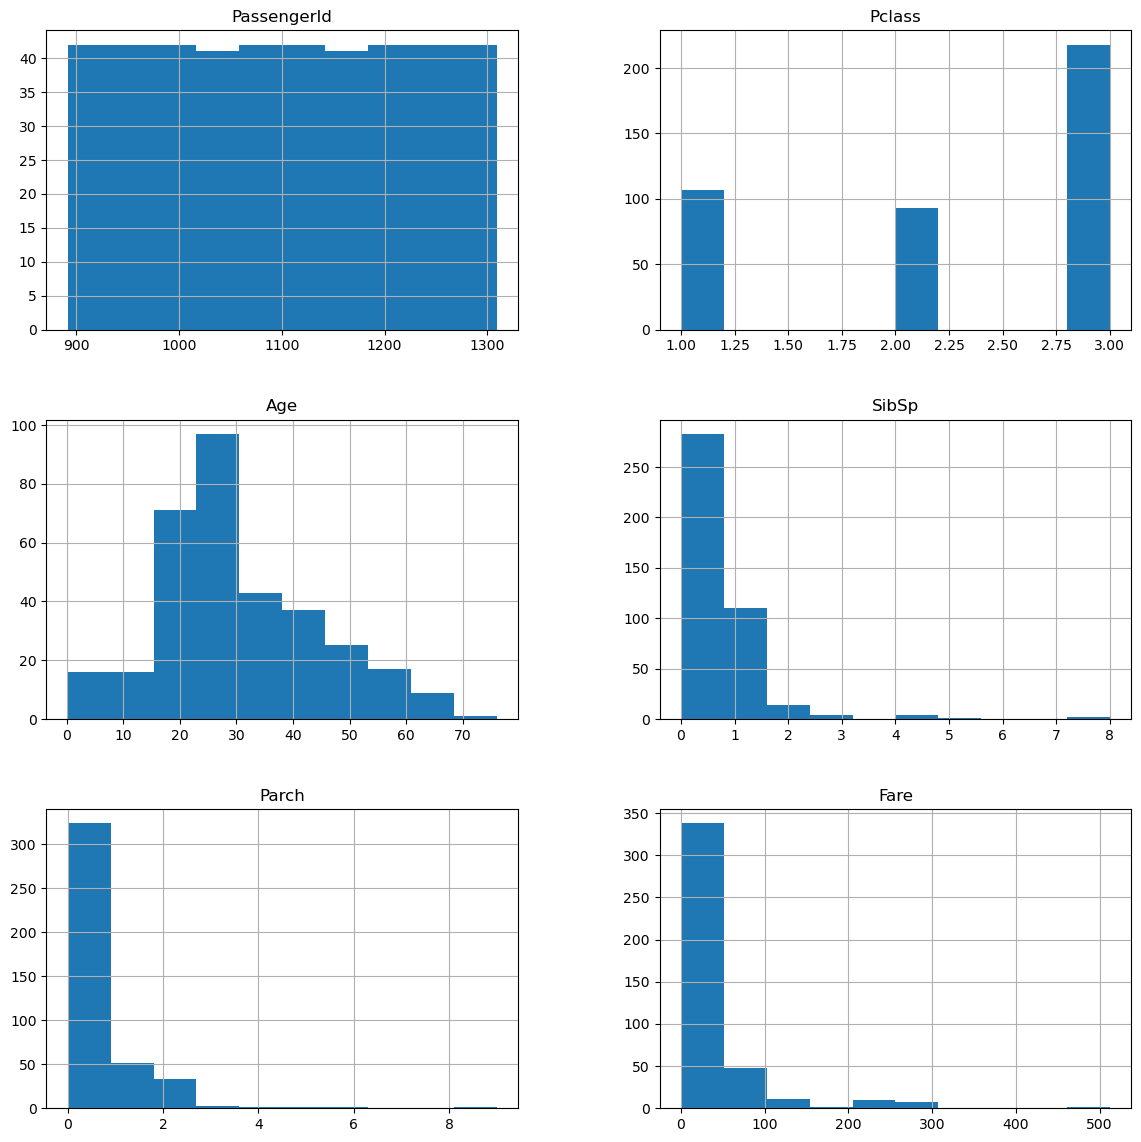

In [8]:
#Examinando las variables nums
test.hist(figsize=(14,14))
plt.show()

In [9]:
#2. Guardar PassangerId para la prediccion
test_ids = test['PassengerId']

In [10]:
# 3. Unir datos para preprocesar de manera uniforme
full = pd.concat([train.drop('Survived', axis=1), test], sort=False)

In [11]:
# 4. Preprocesamiento
# a. Llenar valores nulos
full['Age'] = full['Age'].fillna(full['Age'].median())
full['Fare'] = full['Fare'].fillna(full['Fare'].median())
full['Embarked'] = full['Embarked'].fillna(full['Embarked'].mode()[0])

In [12]:
# b. Codificar variables categóricas
le_sex = LabelEncoder()
full['Sex'] = le_sex.fit_transform(full['Sex'])

le_embarked = LabelEncoder()
full['Embarked'] = le_embarked.fit_transform(full['Embarked'])

In [13]:
# c. Seleccionar variables relevantes
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_all = full[features]


In [20]:
# 5. Separar nuevamente en train y test
X_train = X_all.iloc[:len(train)]
y_train = train['Survived']
X_test = X_all.iloc[len(train):]

In [21]:
# 6. Entrenar modelo RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [22]:
# 7. Predecir sobre el test set
y_pred = clf.predict(X_test)

In [24]:
# 8. Crear archivo predicciones
Predicciones = pd.DataFrame({'PassengerId': test_ids, 'Survived': y_pred})
Predicciones.to_csv('submission.csv', index=False)

In [17]:
print("¡Listo! El archivo Predicciones.csv ha sido creado.")

¡Listo! El archivo submission.csv ha sido creado.
